# Visualizing Racial Tweets with Word Clouds

In [1]:
#Get directory path
import os
#os.chdir('/Users/valery/documents/Cultivate/cultivate_test') 
os.getcwd( )

'/Users/valery/Documents/Springboard/Capstone 2'

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Read in the data
df = pd.read_stata('tweets_training_set.dta')
print(df.shape)
df.columns

(6481, 51)


Index(['statename', 'stateabbr', 'statefip', 'tweetidg', 'tweet', 'sentcat_l',
       'groupref_l', 'food_l', 'exclude_l', 'notes', 'nonfoodlocation',
       'ambiguous', 'nstatedenominator', 'county', 'zipcode', 'tract2010',
       'happy', 'username', 'timestamp', 'timezone', 'followers', 'latitude',
       'longitude', 'negative', 'racecat', 'raceterm', 'raceterm2',
       'raceterm3', 'raceterm4', 'raceterm5', 'sentrace', 'race', 'blackcat',
       'middlecat', 'hispcat', 'asiancat', 'sentblack', 'sentmiddle',
       'senthisp', 'sentasian', 'middlecat1', 'hispcat1', 'sentmiddle1',
       'senthisp1', 'coder', 'AR', 'sentcat3', 'happy_manual', 'sad_manual',
       'tract2010s', 'nstate'],
      dtype='object')

### Check the structure of the tweet column

In [7]:
df['tweet'].head()

0                 I'm the type of nigga tryna get rich
1                               @SheBlasiannn Smuckers
2    @proteinwisdom We even make Japanese cars and ...
3    I wanted to see my nigga when I went back home...
4    Wth stevo is that a nigga? https://t.co/5VNuHv...
Name: tweet, dtype: object

#### It appears that the tweets contain urls. Let's see how many of them.

In [8]:
df_co = df['tweet'].loc[df['tweet'].str.contains('https:')]
#df_co.to_csv('/Users/valery/Documents/Springboard/Capstone 2/co.csv')
df_co.shape

(2577,)

#### Nearly half of the tweets have urls in them. I will need to remove these during preprocessing.

### Create a sparse matrix for positive, negative, and neutral labels

In [4]:
df_sparse = pd.DataFrame(data = df, columns = ['tweetidg', 'tweet', 'happy_manual', 'sad_manual'])

#Create columns: positive, negative, neutral
df_sparse['positive'] = df_sparse['happy_manual']
df_sparse['negative'] = df_sparse['sad_manual'] 

#set up neutral values as 1 if happy_manual and sad_manual are both zero
df_sparse['neutral'] = np.where(df_sparse['happy_manual'] == df_sparse['sad_manual'], 1.0, 0.0)

df_sparse = df_sparse.drop(['happy_manual', 'sad_manual'], axis=1)
df_sparse.columns

Index(['tweetidg', 'tweet', 'positive', 'negative', 'neutral'], dtype='object')

#### Create a table to examine the distribution of tags

In [5]:
df_stats = df_sparse.drop(['tweetidg', 'tweet'], axis=1)
counts = []
categories = list(df_stats.columns.values)
for i in categories:
    counts.append((i, df_stats[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,positive,1642.0
1,negative,1977.0
2,neutral,2862.0


Text(0.5, 0, 'category')

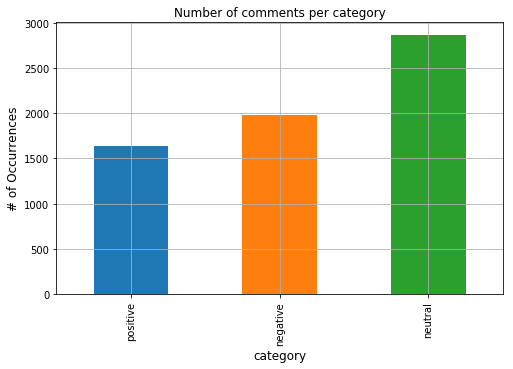

In [6]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

## Preprocessing

In [7]:
import re
#Define a function to clean the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"https://t.co/\S+", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub(r"co", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

#Clean the text
df_sparse['tweet'] = df_sparse['tweet'].map(lambda com : clean_text(com))

## Featurize the data

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
cv_fit=cv.fit_transform(df_sparse['tweet'])

cv_fit.shape

(6481, 14261)

In [9]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_trans = TfidfTransformer()
X_train_tfidf = tfidf_trans.fit_transform(cv_fit)

X_train_tfidf.shape

(6481, 14261)

### Visualize the data

#### Use a cumulative distribution function to determine the minimum and maximum words needed to capture the variation in the data


In [12]:
words = cv_fit.toarray()
words = words.astype(dtype=bool)
numlist = [0]*len(words[0])
for word in words:
    numlist += word
print(numlist[1:10])
type(numlist)

[7 1 1 2 1 3 2 1 1]


numpy.ndarray

In [13]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n

    return x, y

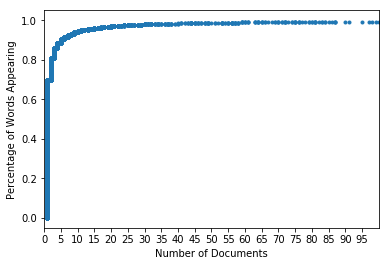

In [14]:
# Compute ECDF 
x, y = ecdf(numlist)

# Generate plot
_ = plt.plot(x, y, marker='.', linestyle='none')
plt.rcParams["figure.figsize"] = [10,5]

# Label the axes
_ = plt.xlim(0,100)
_ = plt.xticks(np.arange(0, 100, step=5))
_ = plt.xlabel('Number of Documents')
_ = plt.ylabel('Percentage of Words Appearing')


# Display the plot
plt.show()

#### Figure 1. ECDF for tweets in the corpus.

This graph shows that most of words are found within the first 25 tweets. We can set the df_min = 1 and the df_max = 15

## Visualize with a word cloud all of the tweets

In [15]:
# Start with loading all necessary libraries
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [16]:
# Make text for all tweets
text = list(df_sparse['tweet'].values)

summary1 = []
for i in range(len(text)):
    summary = ' '.join(str(x) for x in text)
    summary1.append(summary) 
alltext = summary1[0] 

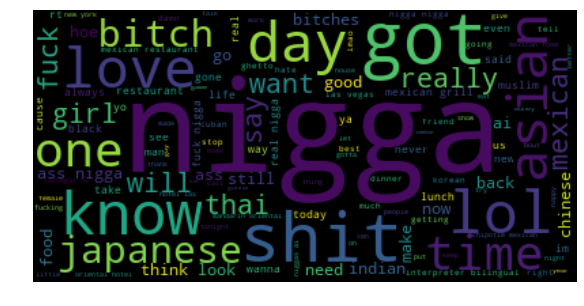

In [17]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(alltext)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# Save the image in the img folder:
wordcloud.to_file('/Users/valery/Documents/Springboard/Capstone 2/racecloud.png')
plt.show()

In [ ]:
#### Fig 2. Word cloud for all the tweets.

### Vizualize with word clouds for each category: Positive, Negative, Neutral

In [18]:
# Make text for each category tweets
df_pos = df_sparse[df_sparse['positive'] == 1]
df_neg = df_sparse[df_sparse['negative'] == 1]
df_neut = df_sparse[df_sparse['neutral'] == 1]

text_pos = list(df_pos['tweet'].values)
text_neg = list(df_neg['tweet'].values)
text_neut = list(df_neut['tweet'].values)



In [19]:
#Positive tweets
summary_pos = []
for i in range(len(text_pos)):
    summary = ' '.join(str(x) for x in text_pos)
    summary_pos.append(summary) 
alltext_pos = summary_pos[0] 


In [20]:
#Negative tweets
summary_neg = []
for i in range(len(text_neg)):
    summary = ' '.join(str(x) for x in text_neg)
    summary_neg.append(summary) 
alltext_neg = summary_neg[0] 


In [21]:
#Neutral tweets
summary_neut = []
for i in range(len(text_pos)):
    summary = ' '.join(str(x) for x in text_neut)
    summary_neut.append(summary) 
alltext_neut = summary_neut[0] 


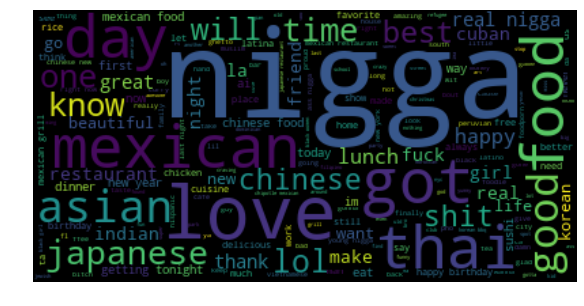

In [22]:
# Create and generate a word cloud image for positive tweets:
wordcloud = WordCloud().generate(alltext_pos)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# Save the image in the img folder:
wordcloud.to_file('/Users/valery/Documents/Springboard/Capstone 2/racecloud_pos.png')

plt.show()

#### Fig 3. Word cloud for positive tweets.

Note that many of the swear words are missing. Positive words such as "beautiful", "happy", "thank" and "good" are present. 

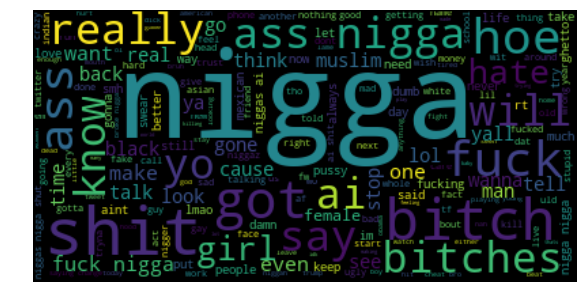

In [23]:
# Create and generate a word cloud image for negative tweets:
wordcloud = WordCloud().generate(alltext_neg)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# Save the image in the img folder:
wordcloud.to_file('/Users/valery/Documents/Springboard/Capstone 2/racecloud_neg.png')

plt.show()

#### Fig 4. Word cloud for negative tweets.

This word cloud contains many swear words! Note that 'girl' is larger here, inticating that it is present more often. Here also are disparaging words used against females. Negative words such as "stop" and "hate" are found here. 

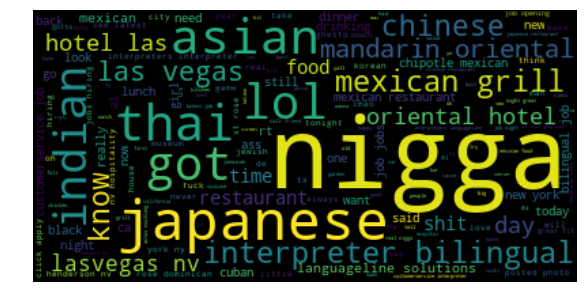

In [24]:
# Create and generate a word cloud image for neutral tweets:
wordcloud = WordCloud().generate(alltext_neut)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# Save the image in the img folder:
wordcloud.to_file('/Users/valery/Documents/Springboard/Capstone 2/racecloud_neut.png')

plt.show()

#### Figure 5. Word cloud for neutral tweets.

There are fewer swear words. Many more words referring to ethnic food and "las vegas". 

Conclusion:  These word clouds indicate that there is a qualitative difference in the labeled tweets for positive, negative, and neutral categories. All of the categories have the word "nigga" used predominantly, giving this word an ambiguous meaning. This illustrates the difficulty that an unsupervised classifier or cluster algorithm would have in determining sentiment.

The next stage will be to test supervised classifiers and develop a model that can predict the labels "positive", "negative", and "neutral" on unlabeled tweets. 

Finally, the predicted labels will be used to generate a U.S. cloropleth heatmap by county.